# Installing Modules & Importing Libraries


In [73]:
%pip install haversine
%pip install opencage
%pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
import pandas as pd
import plotly.express as px
import random
import numpy as np
from haversine import haversine
from scipy.stats.mstats import gmean
%matplotlib inline
from matplotlib import pyplot as plt
from timeit import repeat      
from functools import partial  
import statistics
random.seed(123)

# Load Dataset

In [75]:
def get_data(n_sample=0):
  df=pd.read_csv('Merged_Final.csv')

  df.rename(
    columns={
      "County Name":"county",
      "Facility_Name": "facility",
      "Full_Address": "address",
      "State": "state",
      "Total": "weight",
      "latitudes": "lat",
      "longitudes": "long"
    }, 
    inplace=True)
  
  # dropping rows for hospitals in Alaska & Hawaii & Haiti to only focus on Mainland US
  df = df[(df["state"] != "HI") & (df["state"] != "AK") & (df["lat"] > 19)]
  
  # drop rows with weights = 0
  df = df[df["weight"]>0]

  #drop NA
  df = df.dropna()
  
  if n_sample > 0: 
    df=df.sample(n_sample)

  df = df.reset_index(drop=True)
  return df

































































































































































































































# Visualisation

In [76]:
fig = px.scatter_geo(get_data(), 
                     lat="lat",
                      lon="long",
                      hover_name="facility",
                      opacity=0.5,
                      size="weight",
                     labels={"legend": "Number of COVID-19 cases per county"}
                       )

fig.update_layout(
        title = 'Hospitals in the US',
        geo = dict(scope='usa'),
    )

In [77]:
def viz_scatter(df, centroids):
  '''
  Given a dataframe and coordinates of centroids, 
  returns plotly.express figure containing scatterplot of datapoints 
  e.g.
  >>> viz_scatter(pd.DataFrame({
        "lat": [1.000, 2.000, 3.000],
        "long": [1.000, 2.000, 3.000],
        "centroid": [1, 2, 1]
      }),
      {
      1: [1.000, 1.000],
      2: [2.000, 2.000]
      }
  )
  return plotly.express figure containing scatterplot of datapoints 
  '''

  df["centroid"] = df["centroid"].astype(str)
  fig = px.scatter_geo(df.sort_values(by="centroid"),
                      lat="lat",
                      lon="long",
                      hover_name="facility",
                      color="centroid",
                      category_orders={"centroid": list(centroids.keys())},
                      opacity=0.5,
                      size="weight"
                       )

  fig.update_layout(
          title = 'Hospitals in the Mainland US',
          geo = dict(scope='usa'),
      )
  return fig

In [78]:
def viz_centroids(df, centroids):
  '''
  Given a dataframe and coordinates of centroids, 
  returns plotly.express figure containing scatterplot of centroids
  e.g.
  >>> viz_centroids(pd.DataFrame({
        "lat": [1.000, 2.000, 3.000],
        "long": [1.000, 2.000, 3.000],
        "centroid": [1, 2, 1]
      }),
      {
      1: [1.000, 1.000],
      2: [2.000, 2.000]
      }
  )
  return plotly.express figure containing scatterplot of centroids
  '''

  df_cens = pd.DataFrame.from_dict(dict(
                            zip(
                                ["centroid", "lat", "long"],
                                [list(centroids.keys())]
                                +list(list(each) for each in zip(*list(centroids.values())))
                            )
                        )
    )
  df_cens["centroid"] = df_cens["centroid"].astype(str)
  fig = px.scatter_geo(df_cens,
                      lat="lat",
                      lon="long",
                      # hover_name="centroid",
                      category_orders={"centroid": list(centroids.keys())},
                      symbol_sequence=["cross"],
                      color_discrete_sequence=["black"],
                      )

  fig.update_layout(
          title = 'Centroids of each cluster',
          geo = dict(scope='usa'),
      )

  return fig

In [79]:
def viz(df, centroids):
  '''
  Given a dataframe and coordinates of centroids, 
  shows scatterplot of datapoints and centroids of each centre
  e.g.
  >>> viz(pd.DataFrame({
        "lat": [1.000, 2.000, 3.000],
        "long": [1.000, 2.000, 3.000],
        "centroid": [1, 2, 1]
      }),
      {
      1: [1.000, 1.000],
      2: [2.000, 2.000]
      }
  )
  return None
  '''

  fig = viz_scatter(df, centroids)

  fig.add_trace(viz_centroids(df, centroids).data[0])
  fig.show()

# Core Functions

In [80]:
# Modified from: https://www.kdnuggets.com/2020/06/centroid-initialization-k-means-clustering.html

def init_centroids_plusplus(k: int, df: pd.DataFrame, random_state=42):
    """
    Given a dataframe and integer k, it generates picks k initial centroids 
    for clustering using the k++ method
    
    e.g.
    >>> init_centroids_plusplus(k=2, df=pd.DataFrame({
      "lat": [1.000, 2.000, 3.000],
      "long": [1.000, 2.000, 3.000],
      "weight": [100, 200, 300]
    }))
    returns (
      {
        1: [1.000, 1.000],
        2: [2.000, 2.000]
        }
      )
    """

    ds=np.array(df[["lat", "long"]].values.tolist()) #line added to modify input

    np.random.seed(random_state)
    centroids = [ds[0]]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return {k+1:list(v) for k,v in enumerate(centroids)} #line added to modify output

In [81]:
def init_centroids_lloyds(k: int, df: pd.DataFrame):
  '''
  Given a dataframe and integer k, it randomly picks k data points 
  to be the initial centroids for clustering. 

  e.g.
  >>> init_centroids_lloyds(k=2, df=pd.DataFrame({
    "lat": [1.000, 2.000, 3.000],
    "long": [1.000, 2.000, 3.000],
    "weight": [100, 200, 300]
  }))
  returns (
    {
      1: [1.000, 1.000],
      2: [2.000, 2.000]
      }
    )
  '''
  # generate dictionary of coordinates by picking k random rows from df
  return {k+1:v for k,v in enumerate(df.sample(k)[["lat", "long"]].values.tolist())}

In [82]:
def calc_centroids(k: int, df: pd.DataFrame):
  '''
  Given a dataframe and number of clusters, 
  returns coordinates of centroids which are weighted geographic means of points assigned to a cluster

  e.g.
  >>> calc_centroids(k=5, df=pd.DataFrame({
    "lat": [1.000, 2.000, 3.000],
    "long": [1.000, 2.000, 3.000],
    "weight": [100, 200, 300]
    "centroid": [1, 2, 1]
  }))
  return {
      1: [1.000, 1.000],
      2: [2.000, 2.000]
      }
  '''

  # initialise dictionary to hold coordinates
  cens = {}
  # iterate for each centroid
  for i in range(1, int(k)+1):
    sub_df = df[df["centroid"] == i]

    # cannot calculate geographic mean for negative values, hence, code only works for negative longitudes
    abs_long =  [-x for x in sub_df["long"]]

    # add key, value to dictionary
    cens[i]=[
        gmean(sub_df["lat"], weights=sub_df["weight"]), 
        -gmean(abs_long, weights=sub_df["weight"])
        ]
  return cens

In [83]:
def nearest_centroid(d_loc: list , centroids: dict):
  '''
  Given the coordinates of a data point and coordinates of centroids,
  returns the label of weighted closest centroid

  e.g.
  >>> nearest_centroid(
    d_loc=[1.000, 1.000], 
    centroids={
                1: [1.000, 1.000],
                2: [2.000, 2.000]
                },
    )
  returns 1
  '''
  # initialise holders
  nearest = -1
  dist2nearest = 10**1000

  # iterate for each centroid
  for c in centroids.keys():

    # get coordinates of each centroid
    c_loc = centroids[c]

    # if distance between point and centroid is less than current smallest distance
    if haversine(c_loc, d_loc) <= dist2nearest:
      # reassign label of nearest centroid and the distance to nearest centroid
      nearest = c
      dist2nearest = haversine(c_loc, d_loc)
  
  # return label of nearest centroid
  return int(nearest)

In [84]:
def assign2centroids(df: pd.DataFrame, centroids: dict):
  '''
  Given a dataframe and coordinates of centroids, 
  returns the dataframe with each point assigned to the nearest weighted centroid 
  e.g.
  >>> assign2centroids(
    df=pd.DataFrame({
        "lat": [1.000, 2.000, 3.000],
        "long": [1.000, 2.000, 3.000],
        "weight": [100, 200, 300],
        "centroid": [1, 2, 1]
      }),
    centroids={
      1: [1.000, 1.000],
      2: [2.000, 2.000]
      }
  )
  return pd.DataFrame({
        "lat": [1.000, 2.000, 3.000],
        "long": [1.000, 2.000, 3.000],
        "weight": [100, 200, 300],
        "centroid": [1, 2, 1]
      })
  '''

  # iterate for each data point
  for i in range(len(df)):

    # get each row 
    row = df.iloc[i]
    
    # assign data points to nearest centroids
    df.at[i, "centroid"] = nearest_centroid([row["lat"], row["long"]], centroids)
  return df

# Final K-means

In [86]:
""" PSEUDO CODE

choose k as the number of centroids

generate initial centroids using chosen method

while converging: 
  
  for each datapoint d:
    
    for each centroid c:
      compute sum of squared distances from d to c
    
    assign d to c with nearest weighted centroid 
  
  recalculate centroids

end if assignment to centroids no longer change

"""

' PSEUDO CODE\n\nchoose k as the number of centroids\n\ngenerate initial centroids using chosen method\n\nwhile converging: \n  \n  for each datapoint d:\n    \n    for each centroid c:\n      compute sum of squared distances from d to c\n    \n    assign d to c with nearest weighted centroid \n  \n  recalculate centroids\n\nend if assignment to centroids no longer change\n\n'

In [87]:
def k_means(k: int, df: pd.DataFrame, show_viz=False, init_method="++", printout=False):
    '''
    Given a dataframe and number of clusters, 
    it clusters the data and returns dataframe with each datapoint assigned to a cluster, 
    latitude and longitude of the centroids of each cluster 
    and the sum of squared errors for each cluster

    e.g.
    >>> k_means(k=5, df=pd.DataFrame({
      "lat": [1.000, 2.000, 3.000],
      "long": [1.000, 2.000, 3.000],
      "weight": [100, 200, 300]
    }))
    returns (
      pd.DataFrame({
        "lat": [1.000, 2.000, 3.000],
        "long": [1.000, 2.000, 3.000],
        "weight": [100, 200, 300]
        "centroid": [1, 2, 1],
      }), 
      {
        1: [21.000, 32.000],
        2: [22.000, 33.000]
        },
      125.9999
      )
    '''

    # initialisation methods
    if init_method =="hartiganwong": # Hartigan-Wong Initialisation
      df["centroid"]=[random.randint(1, k) for _ in range(len(df))]
      centroids = calc_centroids(k, df)
     
    elif init_method =="++": # k++ Initialisation  
      df["centroid"]=[-1 for _ in range(len(df))]
      centroids = init_centroids_plusplus(k, df)
      df = assign2centroids(df, centroids)
    
    elif init_method =="lloyds": # Lloyd's initialisation
      df["centroid"]=[-1 for _ in range(len(df))]
      centroids = init_centroids_lloyds(k, df)
      
    else: 
      raise Exception("Initialisation method has to be one of ['hartiganwong', '++', 'lloyds']")

    for iter in range (1, 151): # set max iterations at 150
      # visualise for each iteration
      if printout: print("Iteration", iter)
      if printout: print("Centroids: ", centroids)
      
      if show_viz: 
        viz(df, centroids)

      # assign points to centroid & recalculate centroids
      df = assign2centroids(df, centroids)
      new_centroids = calc_centroids(k, df) 
      
      # if centroids no longer move, end
      if new_centroids == centroids:
        break
      else: 
        centroids = new_centroids
      if iter == 150: 
        print("MAX ITERATIONS EXCEEDED")
    
    # visualise final clustering
    if show_viz: viz(df, centroids)
    
    return (df, centroids)

# Implementation of k-means

In [88]:
sample_df, centroids = k_means(k=4, df=get_data(), printout=True)

Iteration 1
Centroids:  {1: [31.2158271, -85.3634326], 2: [39.64219, -105.032558], 3: [44.5027398, -88.0114646], 4: [40.070111, -74.9818358]}
Iteration 2
Centroids:  {1: [30.081469518347237, -87.551223637423], 2: [34.569486335497906, -114.40268584438907], 3: [41.035544217213086, -87.89208654397883], 4: [40.96211515164137, -74.39785750369616]}
Iteration 3
Centroids:  {1: [30.00347788013716, -89.04759123051197], 2: [34.61679819568694, -116.6508593534961], 3: [40.224726480719966, -88.61614393131784], 4: [40.92349351786653, -74.29972686738328]}
Iteration 4
Centroids:  {1: [29.804391061937746, -89.3110058270295], 2: [34.61258392344629, -116.71156209877265], 3: [39.960141046085845, -88.58949298722838], 4: [40.83549232354511, -74.40678353010185]}
Iteration 5
Centroids:  {1: [29.757084437701014, -89.34132264399655], 2: [34.612408095609545, -116.72493347658647], 3: [39.86137975034915, -88.57309730385951], 4: [40.8480349698256, -74.3986345044053]}
Iteration 6
Centroids:  {1: [29.73542613880147, 

In [89]:
viz(sample_df, centroids)

## Testing over different k values

In [90]:
viz(
    *k_means(k=4, df=get_data())
)

In [91]:
viz(
    *k_means(k=6, df=get_data())
)

In [92]:
viz(
    *k_means(k=8, df=get_data())
)

In [93]:
viz(
    *k_means(k=10, df=get_data())
)

## Testing over different data volumes

In [94]:
get_data().shape

(4428, 7)

In [95]:
viz(
    *k_means(k=4, df=get_data(1000))
)

In [96]:
viz(
    *k_means(k=4, df=get_data(2000))
)

In [97]:
viz(
    *k_means(k=4, df=get_data(3000))
)

In [98]:
viz(
    *k_means(k=4, df=get_data(4000))
)

# Interpreting Results

In [99]:
from geopy.geocoders import Nominatim

geoLoc = Nominatim(user_agent="GetLoc")

## Optimal Location of k DCs

In [100]:


print(centroids, "\n")

print("Optimal DC Locations")
{k:geoLoc.reverse(str(v)[1:-1])[0] for k, v in centroids.items()}

{1: [29.732758599206797, -89.36573852249808], 2: [34.61307538564472, -116.72272681374673], 3: [39.818291404564306, -88.53909953123926], 4: [40.84812154602292, -74.39849332120035]} 

Optimal DC Locations


{1: 'Saint Bernard Parish, Louisiana, United States',
 2: 'Powerline Road, San Bernardino County, California, United States',
 3: 'North 1100 East Road, Piatt County, Illinois, 61913, United States',
 4: '3, Tara Drive, Troy Hills, Parsippany-Troy Hills, Morris County, New Jersey, 07054, United States'}

## Assignment of Hospitals to DCs

In [101]:
sample_df.sort_values(by="centroid")

,county,facility,address,state,weight,lat,long,centroid
0,HOUSTON,SOUTHEAST ALABAMA MEDICAL CENTER,"1108 ROSS CLARK CIRCLE,DOTHAN,HOUSTON,AL",AL,2427,31.215827,-85.363433,1
1675,LAFAYETTE,LAFAYETTE SURGICAL SPECIALTY HOSPITAL,"1101 KALISTE SALOOM RD,LAFAYETTE,LAFAYETTE,LA",LA,912,30.173801,-92.026708,1
1674,LAFAYETTE,PARK PLACE SURGICAL HOSPITAL,"4811 AMBASSADOR CAFFERY PARKWAY,LAFAYETTE,LAFA...",LA,912,30.149395,-92.036379,1
1673,OUACHITA,MONROE SURGICAL HOSPITAL,"2408 BROADMOOR BLVD,MONROE,OUACHITA,LA",LA,52,32.535899,-92.102260,1
1672,SABINE,SABINE MEDICAL CENTER,"240 HIGHLAND DRIVE,MANY,SABINE,LA",LA,36,31.560618,-93.471937,1
...,...,...,...,...,...,...,...,...
3317,MERCER,SHARON REGIONAL HEALTH SYSTEM,"740 EAST STATE STREET,SHARON,MERCER,PA",PA,8583,41.232473,-80.496419,4
3316,PHILADELPHIA,NAZARETH HOSPITAL,"2601 HOLME AVE,PHILADELPHIA,PHILADELPHIA,PA",PA,23925,40.060167,-75.040055,4
3315,BUCKS,DOYLESTOWN HOSPITAL,"595 WEST STATE ST,DOYLESTOWN,BUCKS,PA",PA,6387,40.306794,-75.146598,4
3313,JEFFERSON,PUNXSUTAWNEY AREA HOSPITAL,"81 HILLCREST DRIVE,PUNXSUTAWNEY,JEFFERSON,PA",PA,26142,40.141484,-75.327990,4


## Average Hospital-DC distance for each DC (km)

In [102]:
count_list = list(sample_df.groupby("centroid").count()["lat"])

sum_sse = {k:0 for k in centroids.keys()}

for i in range(len(sample_df)):
  row = sample_df.iloc[i]
  sum_sse[int(row["centroid"])]+= haversine(centroids[int(row["centroid"])], [int(row["lat"]), int(row["long"])])

ave_sse = {k:v/count_list[k-1] for k,v in sum_sse.items()}

In [103]:
print("Average distance from DC to Hospital for each DC")
ave_sse

Average distance from DC to Hospital for each DC


{1: 648.9165990281155,
 2: 757.2386814886006,
 3: 579.107051589054,
 4: 338.80072069129676}

## Relative Size by Weight

In [104]:
agg = sample_df.groupby("centroid").sum()["weight"].values

sum_weight = {k+1:agg[k] for k in range(len(agg))}

In [105]:
sum_weight

{1: 13151267, 2: 25516268, 3: 9429670, 4: 12888160}

# Complexity Analysis

In [106]:
import time
 
nvals = [n for n in range(200,3001,200)]     
k=3

times = []
for n in nvals:
    print("n:", n)
    start = time.time()
    k_means(k, get_data(n))
    k_means(k, get_data(n))
    k_means(k, get_data(n))
    k_means(k, get_data(n))
    k_means(k, get_data(n))
    end = time.time()
    time_taken = ((end-start) * 10**3)/5
    times.append(time_taken)

n: 200
n: 400
n: 600
n: 800
n: 1000
n: 1200
n: 1400
n: 1600
n: 1800
n: 2000
n: 2200
n: 2400
n: 2600
n: 2800
n: 3000


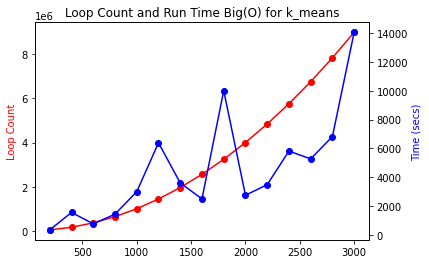

In [107]:
_,ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_ylabel ("Loop Count",color='red')
ax2.set_ylabel("Time (secs)", color='blue')

plt.xlabel('length of dataset (n)')

loopvals=[n**2 for n in nvals]

plt.title('Loop Count and Run Time Big(O) for k_means')  
ax1.plot(nvals, loopvals, 'o-', color='red')
ax2.plot(nvals, times, 'o-', color='blue');

### Plot from above cell:

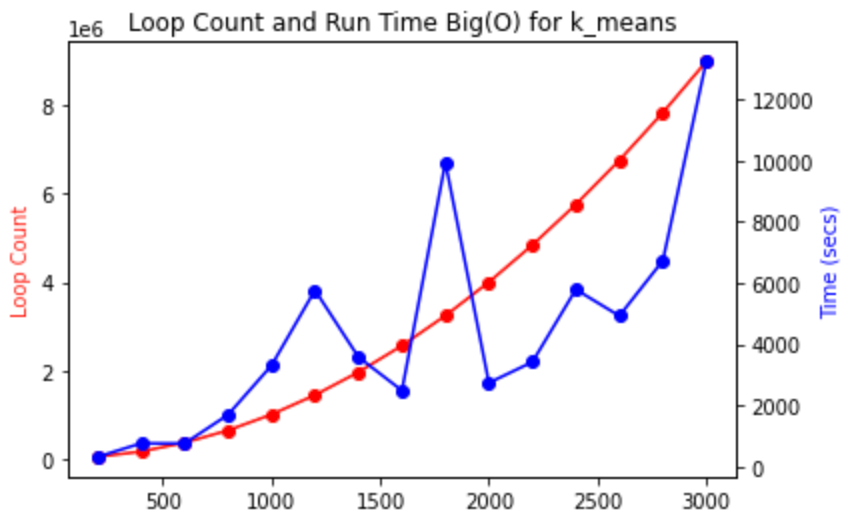

# Finding Optimal K using the Elbow Method

In [113]:
max_k = 8

In [114]:
def get_sse(df, centroids):
  '''
  Given a dataframe and coordinates of centroids, 
  returns sum of squared error of each point to its centroid
  e.g.
  >>> assign2centroids(pd.DataFrame({
        "lat": [1.000, 2.000, 3.000],
        "long": [1.000, 2.000, 3.000],
        "weight": [100, 200, 300],
        "centroid": [1, 2, 1]
      }),
      {
      1: [1.000, 1.000],
      2: [2.000, 2.000]
      }
  )
  return 11500.0000
  '''

  # initalise aggregator of sum of sse
  sum_sse = 0

  # iterate for each data point
  for i in range(len(df)):

    # get each row 
    row = df.iloc[i]

    # add to aggregator distance between each point and its centroid
    sum_sse += haversine(
        [row["lat"], row["long"]],
        centroids[int(row["centroid"])]
    )
  return sum_sse

In [117]:
# get list of errors for each value of k up to max_k
error_list = [get_sse(*k_means(k, df)) for k in range(1, max_k+1)]

In [118]:
error_list

[5652545.8361181,
 3904510.5972879734,
 3192291.186119118,
 2619638.0154700833,
 2289808.932277151,
 1986338.9691089608,
 1776989.2829141854,
 1649158.4099658653]

In [119]:
# create df of errors
df_errors = pd.DataFrame.from_dict(
        dict(
          k=[i for i in range(1, max_k+1)],
          SSE=error_list
        ) 
    )

# produce plot
fig = px.line(df_errors,
              x="k", 
              y="SSE",
              title="SSE for each k", 
              width=800
)

fig.show()

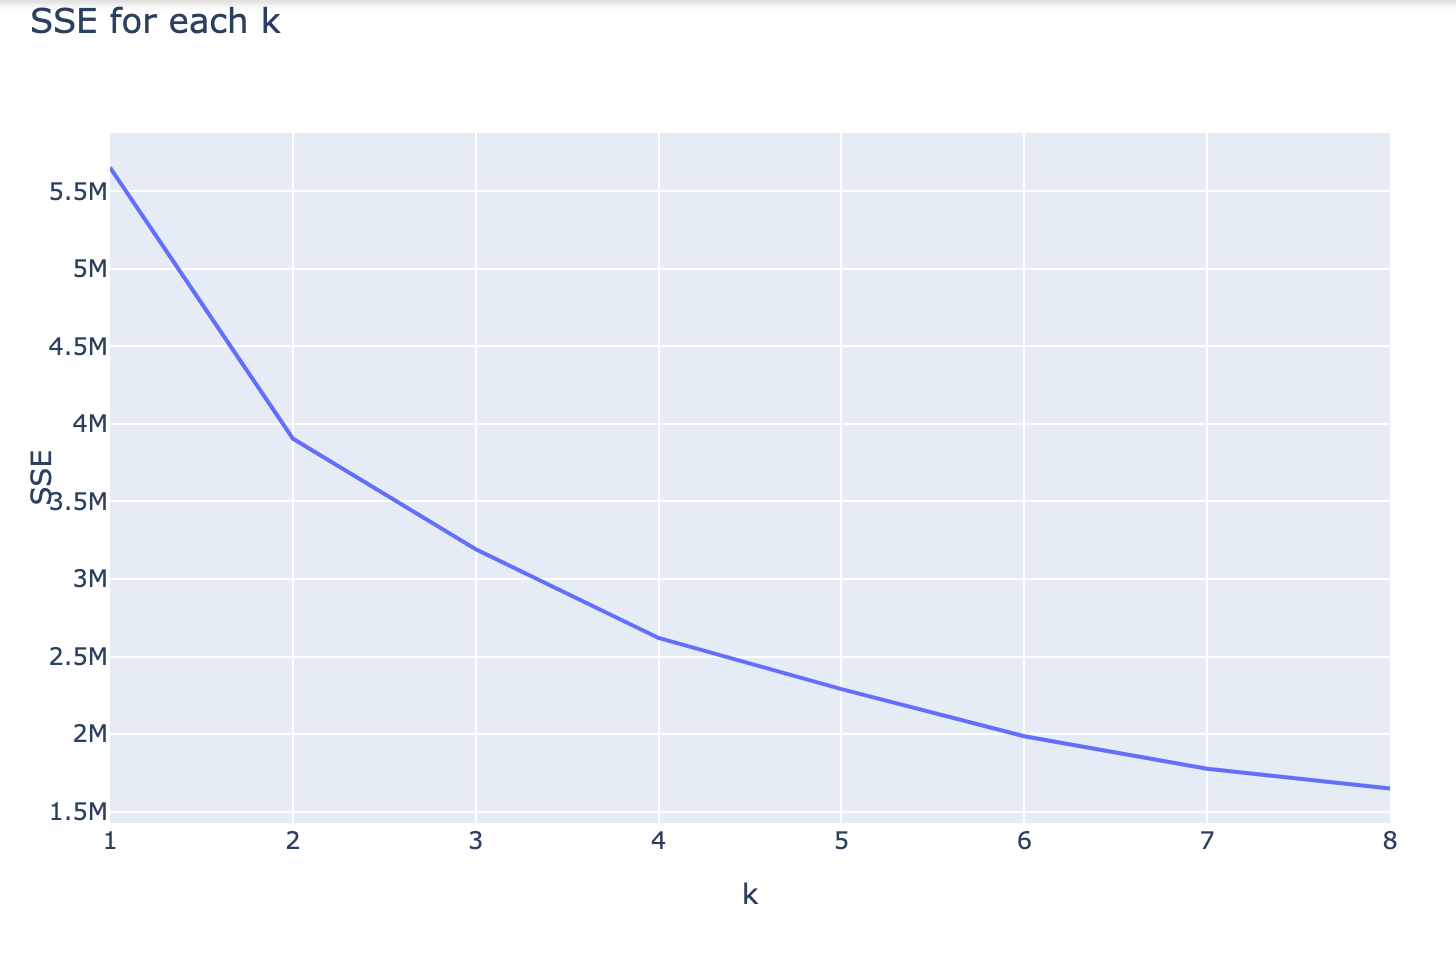

There is no clear elbow, chosen k should be between 2-6. Nevertheless, this depends on the requirements of the DC planners in terms of average DC-to-Hospital distance and size of each DCs. Silouette method could also be used instead.